In [1]:
from sklearn import preprocessing
import pandas as pd
import requests
import json
from pyspark.sql.functions import udf, col, explode
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, ArrayType
from pyspark.sql import Row
from pyspark.sql.types import StructField, StructType, StringType, MapType
from pyspark.sql import SQLContext
import urllib.request
import json
import pickle
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName('weather').enableHiveSupport().config("spark.hadoop.fs.defaultFS", "hdfs://localhost:19000").config("spark.hadoop.ipc.maximum.response.length", "104857600").getOrCreate()

In [6]:
def convert_json_df(jsn):
    df = pd.DataFrame(columns=['city','region','country','lat','lon','tz_id','localtime_epoch','localtime','last_updated',
                               'temp_c','temp_f','is_day','condition_text','condition_icon','condition_code','wind_mph',
                              'wind_kph','wind_degree','wind_dir','pressure_mb','pressure_in','precip_mm','precip_in',
                              'humidity','cloud','feelslike_c','feelslike_f','vis_km','vis_miles','uv','gust_mph','gust_kph'])
    
    new_row = pd.Series({'city':jsn['location']['name'],
                     'region':jsn['location']['region'],
                     'country':jsn['location']['country'],
                     'lat':jsn['location']['lat'],
                     'lon':jsn['location']['lon'],
                     'tz_id':jsn['location']['tz_id'],
                     'localtime_epoch':jsn['location']['localtime_epoch'],
                     'localtime':jsn['location']['localtime'],
                     'last_updated':jsn['current']['last_updated'],
                     'temp_c':jsn['current']['temp_c'],
                     'temp_f':jsn['current']['temp_f'],
                     'is_day':jsn['current']['is_day'],
                     'condition_text':jsn['current']['condition']['text'],
                      'condition_icon':jsn['current']['condition']['icon'],
                      'condition_code':jsn['current']['condition']['code'],
                     'wind_mph':jsn['current']['wind_mph'],
                     'wind_kph':jsn['current']['wind_kph'],
                     'wind_degree':jsn['current']['wind_degree'],
                     'wind_dir':jsn['current']['wind_dir'],
                     'pressure_mb':jsn['current']['pressure_mb'],
                     'pressure_in':jsn['current']['pressure_in'],
                     'precip_mm':jsn['current']['precip_mm'],
                     'precip_in':jsn['current']['precip_in'],
                     'humidity':jsn['current']['humidity'],
                     'cloud':jsn['current']['cloud'],
                     'feelslike_c':jsn['current']['feelslike_c'],
                     'feelslike_f':jsn['current']['feelslike_f'],
                     'vis_km':jsn['current']['vis_km'],
                     'vis_miles':jsn['current']['vis_miles'],
                     'uv':jsn['current']['uv'],
                     'gust_mph':jsn['current']['gust_mph'],
                     'gust_kph':jsn['current']['gust_kph']})
    df = pd.concat([
                df,
                pd.DataFrame([new_row], columns=new_row.index)]
           ).reset_index(drop=True)
    
    spark_df = spark.createDataFrame(df)
    
    return spark_df

In [7]:
from pypostalcode import PostalCodeDatabase
pcdb = PostalCodeDatabase()
postal_dict = {}
postal_code = []
pc = 'P7C'
radius = 1000
results = pcdb.get_postalcodes_around_radius(pc, radius)
for r in results:
    postal_dict[r.city] = r.postalcode

postal_code = list(postal_dict.values())

In [10]:
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [11]:

try:
      
    with urllib.request.urlopen("http://api.weatherapi.com/v1/current.json?key=047b59e9777c48ee95312730233011&q=P7C") as url:
        s = url.read()
        #print(str(s)[2:-1])
        y = json.loads(str(s)[2:-1])
        tmp_df = convert_json_df(y)
  
       
except:

    print('Error')

counter = 0
for i in postal_code:    
    try:
      
      with urllib.request.urlopen("http://api.weatherapi.com/v1/current.json?key=047b59e9777c48ee95312730233011&q="+str(i)) as url:
        s = url.read()
        #print(str(s)[2:-1])
        y = json.loads(str(s)[2:-1])
        tmp_df = tmp_df.union(convert_json_df(y))
        counter +=1
        print('\nCounter : '+str(counter))
        if(counter==20):
            break
       
    except:

        print('Error')
        
tmp_df_2 = tmp_df.select('city','country','lat','lon','temp_c','wind_kph','feelslike_c')


from pyspark.ml.feature import StringIndexer
 
indexer = StringIndexer(inputCol="city", outputCol="cityIndex") 
indexed_df = indexer.fit(tmp_df_2).transform(tmp_df_2) 

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
vectorAssembler = VectorAssembler(inputCols = ['temp_c', 'wind_kph','cityIndex'], outputCol = 'features')
tindexed = vectorAssembler.transform(indexed_df)
# tindexed_f = tindexed.select(['features'])
splits = tindexed.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]



Counter : 1

Counter : 2

Counter : 3

Counter : 4

Counter : 5
Error

Counter : 6

Counter : 7

Counter : 8

Counter : 9

Counter : 10

Counter : 11

Counter : 12

Counter : 13

Counter : 14

Counter : 15

Counter : 16

Counter : 17

Counter : 18

Counter : 19

Counter : 20


In [13]:
tmp_df.write.save('/weather/new.csv', format='parquet', mode='append')

In [14]:
# sqlContext = SQLContext(spark)
# dd = sqlContext.read.format('parquet').load('/weather/new.csv')

In [17]:
tmp_df_2 = tmp_df.select('city','country','lat','lon','temp_c','wind_kph','feelslike_c')

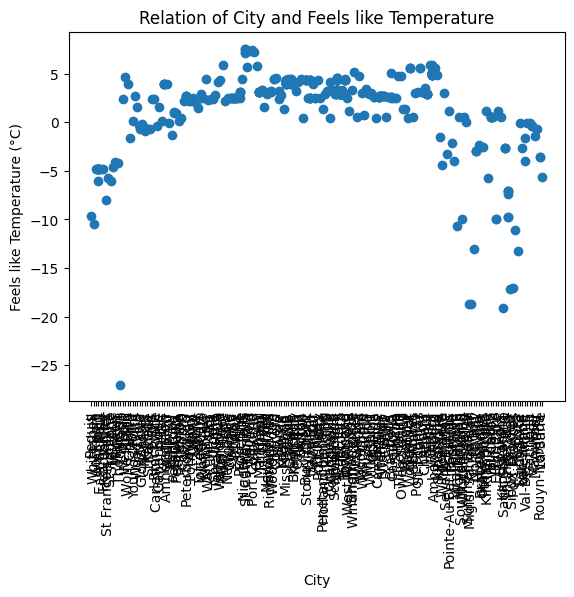

In [18]:
import matplotlib.pyplot as plt



sampled_data = tmp_df_2.select('city', 'feelslike_c').sample(False, 0.8).toPandas()

plt.scatter(sampled_data['city'], sampled_data['feelslike_c'])
plt.xticks(rotation=90)
plt.xlabel('City')
plt.ylabel('Feels like Temperature (°C)')
plt.title('Relation of City and Feels like Temperature')
plt.show()


In [19]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='feelslike_c', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.9502210284424141,0.0,0.0]
Intercept: -3.662807678744957


In [20]:
y_pred = lr_model.transform(test_df)

In [21]:
truth = test_df.select('feelslike_c')
predicted = y_pred.select('prediction')

In [22]:
from pyspark.sql.functions import row_number,lit
from pyspark.sql.window import Window

#add column to each DataFrame called 'id' that contains row numbers from 1 to n
w = Window().orderBy(lit('A'))
df1 = truth.withColumn('id', row_number().over(w))
df2 = predicted.withColumn('id', row_number().over(w))

#join together both DataFrames using 'id' column
final_df = df1.join(df2, on=['id']).drop('id')

#view final DataFrame
# final_df.show()

+-----------+-------------------+
|feelslike_c|         prediction|
+-----------+-------------------+
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -4.8| -6.513470764072199|
|       -6.0| -7.463691792514613|
|        3.9| 3.9389605487943555|
|       -1.6|-0.8121445934177149|
|       -0.4|0.13807643502469924|
+-----------+-------------------+
only showing top 20 rows



In [23]:
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType

spark = SparkSession.builder.getOrCreate()

sql_context = SQLContext(spark.sparkContext)

final_df = final_df.withColumn('difference', F.col('feelslike_c') - F.col('prediction'))
final_df = final_df.withColumn('squared_difference', F.pow(F.col('difference'), F.lit(2).astype(IntegerType())))
rmse = final_df.select(F.avg(F.col('squared_difference')).alias('rmse'))

rmse.show()

c:\Users\Deepak Dhingra\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+------------------+
|              rmse|
+------------------+
|1.0324804324791492|
+------------------+

